In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [114]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def check_null_values(self):
        """Checks for null values in the dataframe."""
        print("Null Values Before Cleaning:")
        print(self.dataframe.isnull().sum())

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def print_head(self):
        """Prints the head of the dataframe."""
        print("Head of the DataFrame:")
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print("\nDescription of the DataFrame:")
        print(self.dataframe.describe())

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = self.scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize_open(self):
        """Plots graph for open stock values vs. date."""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Open')
            plt.title('Open Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Open Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Open' columns.")

    def visualize_close(self):
        """Plots graph for close stock values vs. data."""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Close')
            plt.title('Close Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Close Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Close' columns.")                                                

In [115]:
data = Data()

In [116]:
data.read('BAJAJ-AUTO.csv')

Data successfully read from BAJAJ-AUTO.csv.


In [117]:
data.check_null_values()

Null Values Before Cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [118]:
data.clean_data()

Data cleaned: 0 rows removed.


In [119]:
data.print_head()

Head of the DataFrame:
         Date        Open    High         Low       Close   Adj Close   Volume
0  2009-05-29  484.049988  530.00  480.375000  517.125000  349.088226  4015782
1  2009-06-01  514.250000  555.50  490.000000  530.875000  358.370331   813230
2  2009-06-02  532.400024  555.00  520.049988  541.650024  365.644012   371870
3  2009-06-03  549.974976  568.25  538.575012  558.924988  377.305603   769830
4  2009-06-04  558.500000  564.75  538.549988  550.375000  371.533905   391896


In [120]:
data.print_description()


Description of the DataFrame:
              Open         High          Low        Close    Adj Close  \
count  3700.000000  3700.000000  3700.000000  3700.000000  3700.000000   
mean   2725.996195  2758.182591  2693.309274  2724.932143  2352.247040   
std    1376.249199  1390.282720  1362.783484  1377.050109  1467.134788   
min     470.000000   479.225006   453.274994   469.399994   316.871246   
25%    1834.987488  1859.274994  1810.549957  1835.887512  1366.423676   
50%    2638.000000  2665.449951  2611.000000  2636.650024  2194.269409   
75%    3225.000000  3248.962463  3190.200012  3217.724915  2756.492737   
max    9248.950195  9357.950195  9139.500000  9276.099609  9276.099609   

             Volume  
count  3.700000e+03  
mean   4.540888e+05  
std    3.814412e+05  
min    0.000000e+00  
25%    2.477272e+05  
50%    3.582235e+05  
75%    5.357815e+05  
max    8.537143e+06  


In [121]:
data.normalize()

Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


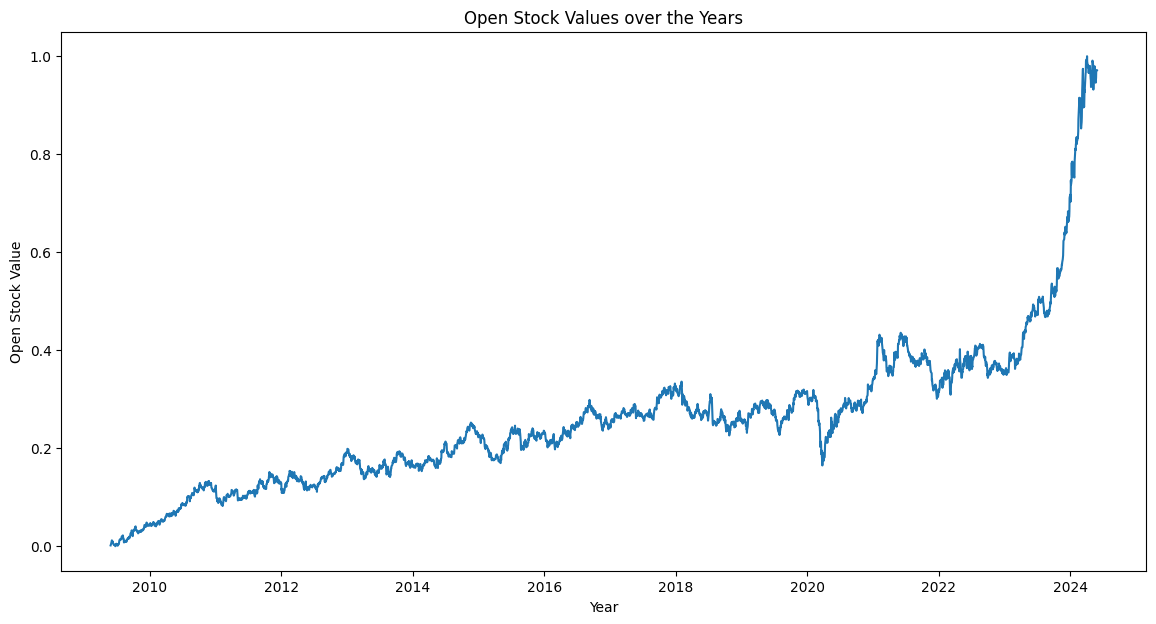

In [122]:
data.visualize_open()

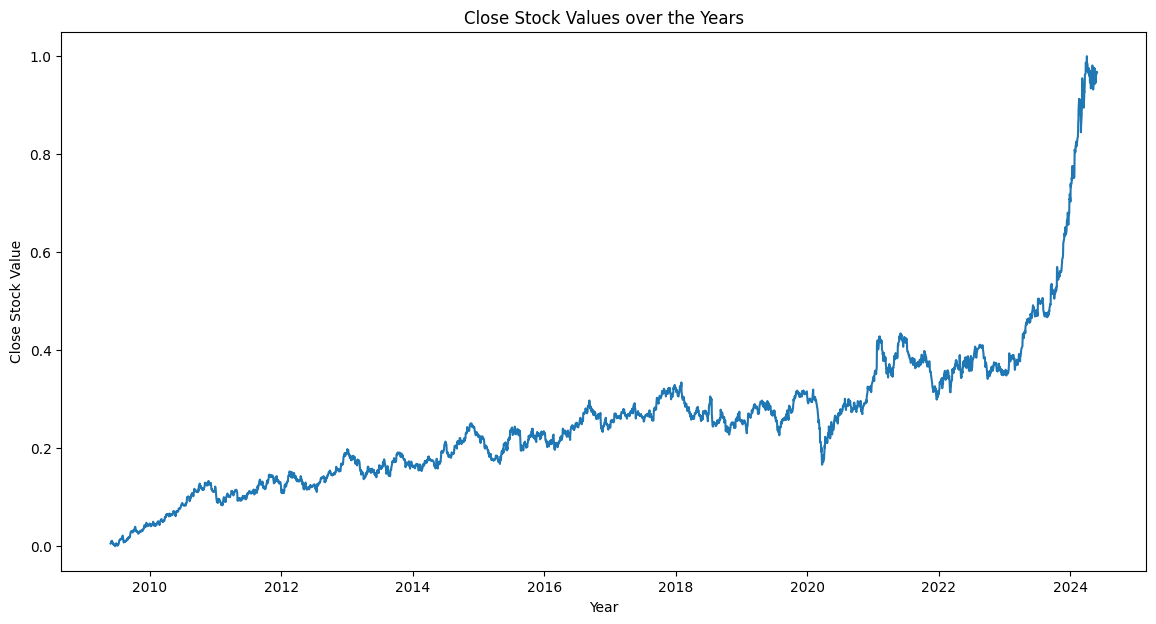

In [123]:
data.visualize_close()

In [124]:
class LSTM_Trainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data(self, feature_col = 'Close', look_back = 60):
        """Prepare data for lstm"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)
       
        x = [] 
        y = [] 
  
        for i in range(len(data) - look_back): 
            x.append(data[i:i + look_back]) 
            y.append(data[i + look_back]) 
  
        x, y = np.array(x), np.array(y) 

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
        return x_train, x_test, y_train, y_test.reshape(-1, 1)


    def build_and_train_lstm(self, feature_col = 'Close', look_back = 60, epochs = 40, batch_size = 32):
        """Build and train the lstm model"""
        x_train, x_test, y_train, y_test = self.prepare_data(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
        model.add(LSTM(units = 50))
        model.add(Dense(1))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
        
        model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test)) 

        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.x_test)
        predictions = predictions.reshape(-1, 1)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.dataframe['Close'].values.reshape(-1, 1)) 
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize = (14, 7))
        plt.plot(actual, label = 'Actual Stock Price')
        plt.plot(predictions, label = 'Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
    def evaluate_model(self):
        """Evaluating the model"""
        predictions = self.model.predict(self.x_test)
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        mse = mean_squared_error(actual, predictions)
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual, predictions)
        
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"R-squared: {r2}")

In [125]:
trainer = LSTM_Trainer(data.dataframe, data.scaler)

In [126]:
trainer.build_and_train_lstm()

C:\Users\saumy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0048 - val_loss: 4.2638e-04
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.3288e-04 - val_loss: 3.7643e-04
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2748e-04 - val_loss: 3.5023e-04
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2163e-04 - val_loss: 3.5172e-04
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1239e-04 - val_loss: 5.6745e-04
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0540e-04 - val_loss: 4.8251e-04
Epoch 7/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.5507e-05 - val_loss: 2.9270e-04
Epoch 8/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0324e-04 - val_loss: 2.8106e-04
Epoch 9/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.1327e-05 - val_loss: 4.5465e-04
Epoch 10/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.8964e-05 - val_loss: 4.0605e-04
Epoch 11/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.6791e-05 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


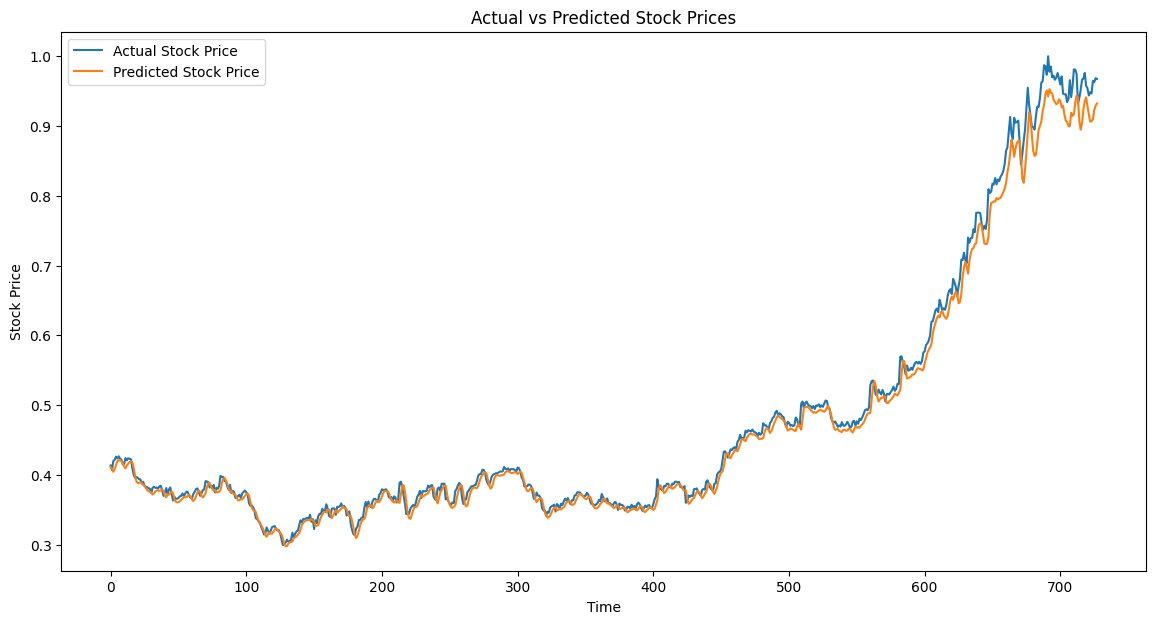

In [127]:
trainer.predict_and_plot()

In [128]:
trainer.evaluate_model()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error: 0.00026891407579076194
Mean Absolute Error: 0.011019683957893522
Root Mean Squared Error: 0.016398599811897414
R-squared: 0.9918788174239014
